In [62]:
from google.colab import files
files.upload()

Saving ダウンロード.png to ダウンロード.png


{'ダウンロード.png': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\xc6\x00\x00\x02\x16\x08\x06\x00\x00\x00TVK\x9a\x00\x00\x00\x04sBIT\x08\x08\x08\x08|\x08d\x88\x00\x00\x00\tpHYs\x00\x00\x0b\x12\x00\x00\x0b\x12\x01\xd2\xdd~\xfc\x00\x00\x009tEXtSoftware\x00matplotlib version 3.0.3, http://matplotlib.org/\x9d\x0b\xab\xa3\x00\x00 \x00IDATx\x9c\xec\xddw|\\\xf5\x9d\xef\xff\xf7\x8cF\xbdX\x92\xd5\x8b%Y\x96\xc6E\xee\x05llp\xc36`\xc0t\x085\t\xc9&\xb0\xd9l\xb6\xfc6\xd9d\xf7n\xf6n\xb6\xfc\x92\xdcl\x92\r\xc9M\x07BLh6\xc5`L\xb11`\x8c{\x91,\x8dmU[\xbd\xf763\xe7\xfeaC\xc0\x80-[3s\xa6\xbc\x9e\x8f\x07\x8f\x07\x964:o}<\x1e\xbdu\xf4=\xdfc1\x0cC\x00\x00\x00@\xa8\xb3\x9a\x1d\x00\x00\x00\x00\xf0\x07\x14c\x00\x00\x00@\x14c\x00\x00\x00@\x12\xc5\x18\x00\x00\x00\x90D1\x06\x00\x00\x00$Q\x8c\x01\x00\x00\x00I\x92\xcd\xec\x00\x1fhm\xed5e\xdf\xb8\xa4\xa4\x18uv\x0e\x98q\xe8\x90\xc2\x9c\xbd\x8f\x19\xfb\x06s\xf6>f\xec\x1b\xcc\xd9\xfb\x98\xb1o\\\xec\x9cSS\xe3-\x9f\xf5\xbe\x90?cl\xb3\x85\x99\x1d!$0g\xefc\xc6\xbe\xc1\x9c\x

# セグメンテーション２　unetのコードリーディング　転移学習
## 問題1コードレビュー
転移学習を使用してセグメンテーションの精度を改善したコードを提示するので、レビューを行ってください。

clean-workflow-in-keras.ipynbでは
バッチノーマライゼーションと残差接続ができるようになっていることがsprint20と変わっている。



03-models_pretrained_and_more.ipynbでは
resnetをロード（重み付き）してブロックをわけデコーダへコンカットしていた。
レイヤーをブロックにまとめることでシンプルなコードにしていた。


In [0]:
#セグメンテーション１で使った実装のunet
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from keras import Model
def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model


In [0]:
#clean-workflow-in-keras.ipynbのunet
from keras import Model
from keras.layers import (Activation, BatchNormalization, Concatenate, Conv2D,
                          Conv2DTranspose, Dropout, Input, MaxPooling2D,
                          UpSampling2D, concatenate)
from keras.optimizers import Adam


def conv_block(m, dim, acti, bn, res, do=0):
    n = Conv2D(dim, 3, activation=acti, padding='same')(m) #フィルターサイズ３の２dconv
    n = BatchNormalization()(n) if bn else n #バッチノーマライゼーションするかしないか　bn
    
    """
    if bn else nしたと一緒
    if bn:
      n = BatchNormalization()(n)
    else
      n
    """
    
    
    n = Dropout(do)(n) if do else n #ドロップアウトするかしないか do=ドロップアウト率 
    n = Conv2D(dim, 3, activation=acti, padding='same')(n) 
    n = BatchNormalization()(n) if bn else n
    return Concatenate()([m, n]) if res else n #残差接続するかしないか res


def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
    if depth > 0:
        n = conv_block(m, dim, acti, bn, res)
        m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n) #マックスプーリングするかconv2dで小さくするか
        m = level_block(m, int(inc * dim), depth - 1, #再起呼び出しを使ってモデルを構築している
                        inc, acti, do, bn, mp, up, res)
        if up: #アップサンプリングかトランスポーずコンボリューションか
            m = UpSampling2D()(m)
            m = Conv2D(dim, 2, activation=acti, padding='same')(m) 
        else:
            m = Conv2DTranspose(dim, 3, strides=2,
                                activation=acti, padding='same')(m)
        n = Concatenate()([n, m]) #エンコーダーの特徴マップとの接続
        m = conv_block(n, dim, acti, bn, res)
    else:
        m = conv_block(m, dim, acti, bn, res, do)
    return m


def UNet(params):

    img_shape = params['input_dim'] #インプットシェイプ
    out_ch = 1 
    start_ch = 8
    depth = 3
    inc_rate = 2.
    activation = 'relu'
    dropout = 0.5
    batchnorm = False
    maxpool = True
    upconv = True
    residual = False

    i = Input(shape=img_shape)
    o = level_block(i, start_ch, depth, inc_rate, activation,
                    dropout, batchnorm, maxpool, upconv, residual)
    o = Conv2D(out_ch, 1)(o)
    # Sigmoid activation is used because model is trained with binary_crossentropy.
    o =  Activation('sigmoid')(o)

    model = Model(inputs=i, outputs=o)
    
    return model
  

#モデル作成部分  
model = UNet({'input_dim': input_dim}) #作成
model.compile(optimizer='adam', loss='binary_crossentropy') #違いなし


early_stopping = EarlyStopping(monitor='val_loss' ,patience=12, verbose=1, mode='min') 
model_checkpoint = ModelCheckpoint("./{}.h5".format(run_name),monitor='val_loss',
                                   save_best_only=True, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',factor=0.33, patience=6, min_lr=1e-6, verbose=1, mode='min')

epochs = 10  # change to more for better score!
batch_size = 32


history = model.fit(X_tr, y_tr,
                    validation_data=[X_val, y_val], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr], 
                    verbose=1)

In [0]:
##03-models_pretrained_and_more.ipynbより

# Decoder blocks:
# Basic decoder block with Conv, BN and PReLU activation.
def decoder_block_simple(
        layer_name, block_name,
        num_filters=32,
        conv_dim=(3, 3)):
#コンボ２d　バッチノーマライゼーション、reluのブロック関数
    x_dec = Conv2D(
        num_filters, conv_dim,
        padding='same',
        name='{}_conv'.format(block_name))(layer_name)
    x_dec = BatchNormalization(
        name='{}_bn'.format(block_name))(x_dec)
    x_dec = PReLU(
        name='{}_activation'.format(block_name))(x_dec)

    return x_dec

# Decoder block with bottleneck architecture, where middle conv layer
# is half the size of first and last, in order to compress representation.
# This type of architecture is supposed to retain most useful information.
def decoder_block_bottleneck(
        layer_name, block_name,
        num_filters=32,
        conv_dim=(3, 3),
        dropout_frac=0.2):
#デコーダーシンプルをまとめたやつ
    x_dec = Conv2D(
        num_filters, conv_dim,
        padding='same',
        name='{}_conv1'.format(block_name))(layer_name)
    x_dec = BatchNormalization(
        name='{}_bn1'.format(block_name))(x_dec)
    x_dec = PReLU(
        name='{}_activation1'.format(block_name))(x_dec)
    x_dec = Dropout(dropout_frac)(x_dec)

    x_dec2 = Conv2D(
        num_filters // 2, conv_dim,
        padding='same',
        name='{}_conv2'.format(block_name))(x_dec)
    x_dec2 = BatchNormalization(
        name='{}_bn2'.format(block_name))(x_dec2)
    x_dec2 = PReLU(
        name='{}_activation2'.format(block_name))(x_dec2)
    x_dec2 = Dropout(dropout_frac)(x_dec2)

    x_dec2 = Conv2D(
        num_filters, conv_dim,
        padding='same',
        name='{}_conv3'.format(block_name))(x_dec2)
    x_dec2 = BatchNormalization(
        name='{}_bn3'.format(block_name))(x_dec2)
    x_dec2 = PReLU(
        name='{}_activation3'.format(block_name))(x_dec2)
    x_dec2 = Dropout(dropout_frac)(x_dec2)

    x_dec2 = Add()([x_dec, x_dec2])

    return x_dec2
  
  
###Model definition:
# Model is parametrized in a way to enable easy change of decoder_block type,
# as this is an argument that can be given a function, like decoder_block_simple.
def unet_resnet(input_size, decoder_block,
                weights='imagenet',
                loss_func='binary_crossentropy',
                metrics_list=[my_iou_metric],
                use_lovash=False):

    # Base model - encoder
    base_model = ResNet50(　　　　　#resnet50をベースモデルに分類機は含めない
        input_shape=input_size, 
        include_top=False,
        weights=weights)
    
    # Layers for feature extraction in the encoder part
    encoder1 = base_model.get_layer('activation_1').output# (None, 112, 112, 64) シェイプが半分になるところを取ってきている
    encoder2 = base_model.get_layer('activation_10').output# (None, 56, 56, 256)  
    encoder3 = base_model.get_layer('activation_22').output# (None, 28, 28, 512)
    encoder4 = base_model.get_layer('activation_40').output#(None, 14, 14, 1024)
    encoder5 = base_model.get_layer('activation_49').output# (None, 7, 7, 2048) 

    # Center block
    center = decoder_block(
        encoder5, 'center', num_filters=512)
    concat5 = concatenate([center, encoder5], axis=-1)#resnetoから出てきたencoder5とコンカットしている。オリジナルにはない要素

    # Decoder part.
    # Every decoder block processed concatenated output from encoder and decoder part.
    # This creates skip connections.
    # Afterwards, decoder output is upsampled to dimensions equal to encoder output part.
    decoder4 = decoder_block(
        concat5, 'decoder4', num_filters=256)#入力がconcat5, フィルターが256のデコーダー
    concat4 = concatenate([UpSampling2D()(decoder4), encoder4], axis=-1)

    decoder3 = decoder_block(
        concat4, 'decoder3', num_filters=128)
    concat3 = concatenate([UpSampling2D()(decoder3), encoder3], axis=-1)

    decoder2 = decoder_block(
        concat3, 'decoder2', num_filters=64)
    concat2 = concatenate([UpSampling2D()(decoder2), encoder2], axis=-1)

    decoder1 = decoder_block(
        concat2, 'decoder1', num_filters=64)
    concat1 = concatenate([UpSampling2D()(decoder1), encoder1], axis=-1)

    # Final upsampling and decoder block for segmentation.
    output = UpSampling2D()(concat1)
    output = decoder_block(
        output, 'decoder_output', num_filters=32)
    output = Conv2D(
        1, (1, 1), activation=None, name='prediction')(output) #predictionするために１１畳み込み
    if not use_lovash:
        output = Activation('sigmoid')(output) 
        
    model = Model(base_model.input, output)
    model.compile(loss=loss_func, optimizer='adam', metrics=metrics_list)

    return model

#問題2コードの書き換え
エンコーダーにResNetが使用されていたコードをVGGに変更してください。

lean-workflow-in-kerasを書き換えました

xcetption https://www.kaggle.com/meaninglesslives/getting-0-87-on-private-lb-using-kaggle-kernel

In [0]:
import gc
import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold
from tqdm import tqdm

from keras import optimizers
from keras.callbacks import *
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import *
from keras.models import Model, load_model, save_model
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.applications.resnet50 import ResNet50, preprocess_input

%matplotlib inline

In [0]:
plt.rcParams['figure.figsize'] = (12, 9)
# plt.style.use('ggplot')

In [0]:
def compute_coverage(df, masks):
    
    df = df.copy()
    
    def cov_to_class(val):
        for i in range(0, 11):
            if val * 10 <= i:
                return i

    # Output percentage of area covered by class
    df['coverage'] = np.mean(masks, axis=(1, 2))
    # Coverage must be split into bins, otherwise stratified split will not be possible,
    # because each coverage will occur only once.
    df['coverage_class'] = df.coverage.map(
        cov_to_class)

    return df


def create_depth_abs_channels(image_tensor):
    image_tensor = image_tensor.astype(np.float32)
    h, w, c = image_tensor.shape
    for row, const in enumerate(np.linspace(0, 1, h)):
        image_tensor[row, :, 1] = const
    image_tensor[:, :, 2] = (
        image_tensor[:, :, 0] * image_tensor[:, :, 1])

    x_dx = np.diff(image_tensor[:, :, 0], axis=0)
    x_dy = np.diff(image_tensor[:, :, 0], axis=1)
    x_dx = cv2.copyMakeBorder(x_dx, 1, 0, 0, 0, cv2.BORDER_CONSTANT, 0)
    x_dy = cv2.copyMakeBorder(x_dy, 0, 0, 1, 0, cv2.BORDER_CONSTANT, 0)
    image_tensor[:, :, 1] = np.abs(x_dx + x_dy)

    return image_tensor

In [33]:
train = pd.read_csv('train.csv')
test = pd.read_csv('sample_submission.csv')
depth = pd.read_csv('depths.csv')

train_src = 'train/'

print('train:\n{}'.format(train.head()))
print('\ntest:\n{}'.format(test.head()))


train = train.merge(depth, how='left', on='id')
test = test.merge(depth, how='left', on='id')

print('\n{}'.format(train.head()))

train:
           id                                           rle_mask
0  575d24d81d                                                NaN
1  a266a2a9df                                          5051 5151
2  75efad62c1  9 93 109 94 210 94 310 95 411 95 511 96 612 96...
3  34e51dba6a  48 54 149 54 251 53 353 52 455 51 557 50 659 4...
4  4875705fb0  1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...

test:
           id rle_mask
0  155410d6fa      1 1
1  78b32781d1      1 1
2  63db2a476a      1 1
3  17bfcdb967      1 1
4  7ea0fd3c88      1 1

           id                                           rle_mask    z
0  575d24d81d                                                NaN  843
1  a266a2a9df                                          5051 5151  794
2  75efad62c1  9 93 109 94 210 94 310 95 411 95 511 96 612 96...  468
3  34e51dba6a  48 54 149 54 251 53 353 52 455 51 557 50 659 4...  727
4  4875705fb0  1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...  797


In [34]:
X_train = np.asarray(
    [cv2.imread('train/images/{}.png'.format(x), 0) for x in train.id.tolist()], 
    dtype=np.uint8) / 255.
y_train = np.asarray(
    [cv2.imread('train/masks/{}.png'.format(x), 0) for x in train.id.tolist()],
    dtype=np.uint8) / 255.

print(X_train.shape, y_train.shape)

(4000, 101, 101) (4000, 101, 101)


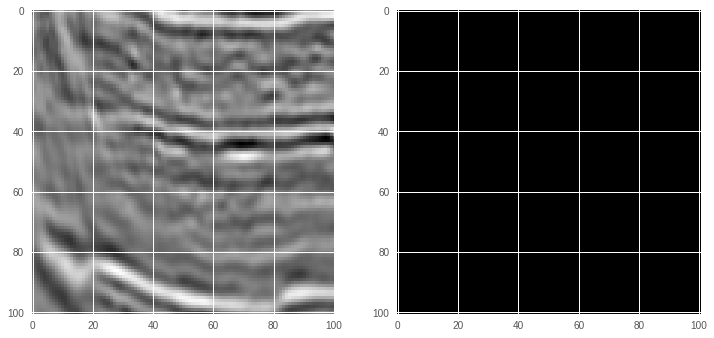

In [35]:
random_index = np.random.randint(0, X_train.shape[0])

fig, ax = plt.subplots(1, 2)

ax[0].imshow(X_train[random_index], cmap='gray')
ax[1].imshow(y_train[random_index], cmap='gray')

In [0]:
train = compute_coverage(train, y_train)

In [37]:
kfold = StratifiedKFold(n_splits=5, random_state=1337)

# Add channel features
X_train_ch = np.repeat(np.expand_dims(X_train, axis=-1), 3, -1)
X_train_ch = np.asarray(list(map(lambda x: create_depth_abs_channels(x), X_train_ch)))

# Resize to 224x224, default ResNet50 image size
X_resized = np.asarray(list(map(lambda x: cv2.resize(x, (224, 224)), X_train_ch)))
y_resized = np.asarray(list(map(lambda x: cv2.resize(x, (224, 224)), y_train)))


for train_index, valid_index in kfold.split(train.id.values, train.coverage_class.values):
    
    X_tr, X_val = X_resized[train_index], X_resized[valid_index]
    y_tr, y_val = y_resized[train_index], y_resized[valid_index]
    
    break
    

y_tr = np.expand_dims(y_tr, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)

print(X_tr.shape, y_tr.shape)
print(X_val.shape, y_val.shape)


del X_train_ch, y_resized
del X_resized
gc.collect()

(3196, 224, 224, 3) (3196, 224, 224, 1)
(804, 224, 224, 3) (804, 224, 224, 1)


112

In [0]:
from keras.losses import binary_crossentropy


# Dice & combined
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score


def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score


def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))



# Lovash loss: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels


def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss


# IoU metric for observation during training
# https://www.kaggle.com/cpmpml/fast-iou-metric-in-numpy-and-tensorflow
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)


# For Lovash loss
def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

In [0]:
# Basic decoder block with Conv, BN and PReLU activation.
def decoder_block_simple(
        layer_name, block_name,
        num_filters=32,
        conv_dim=(3, 3)):

    x_dec = Conv2D(
        num_filters, conv_dim,
        padding='same',
        name='{}_conv'.format(block_name))(layer_name)
    x_dec = BatchNormalization(
        name='{}_bn'.format(block_name))(x_dec)
    x_dec = PReLU(
        name='{}_activation'.format(block_name))(x_dec)

    return x_dec

# Decoder block with bottleneck architecture, where middle conv layer
# is half the size of first and last, in order to compress representation.
# This type of architecture is supposed to retain most useful information.
def decoder_block_bottleneck(
        layer_name, block_name,
        num_filters=32,
        conv_dim=(3, 3),
        dropout_frac=0.2):
#デコーダーブロックのコンボリューションが３つ
    x_dec = Conv2D(
        num_filters, conv_dim,
        padding='same',
        name='{}_conv1'.format(block_name))(layer_name)
    x_dec = BatchNormalization(
        name='{}_bn1'.format(block_name))(x_dec)
    x_dec = PReLU(
        name='{}_activation1'.format(block_name))(x_dec)
    x_dec = Dropout(dropout_frac)(x_dec)

    x_dec2 = Conv2D(
        num_filters // 2, conv_dim,
        padding='same',
        name='{}_conv2'.format(block_name))(x_dec)
    x_dec2 = BatchNormalization(
        name='{}_bn2'.format(block_name))(x_dec2)
    x_dec2 = PReLU(
        name='{}_activation2'.format(block_name))(x_dec2)
    x_dec2 = Dropout(dropout_frac)(x_dec2)

    x_dec2 = Conv2D(
        num_filters, conv_dim,
        padding='same',
        name='{}_conv3'.format(block_name))(x_dec2)
    x_dec2 = BatchNormalization(
        name='{}_bn3'.format(block_name))(x_dec2)
    x_dec2 = PReLU(
        name='{}_activation3'.format(block_name))(x_dec2)
    x_dec2 = Dropout(dropout_frac)(x_dec2)

    x_dec2 = Add()([x_dec, x_dec2])

    return x_dec2

In [48]:
from keras.applications.vgg16 import VGG16
base_model = VGG16(
        input_shape=input_size, 
        include_top=False,
        weights="imagenet")

58892288/58889256 [==============================] - 2s 0us/step


In [51]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
# Model is parametrized in a way to enable easy change of decoder_block type,
# as this is an argument that can be given a function, like decoder_block_simple.
from keras.applications.vgg16 import VGG16
def unet_resnet(input_size, decoder_block,
                weights='imagenet',
                loss_func='binary_crossentropy',
                metrics_list=[my_iou_metric],
                use_lovash=False):

    # Base model - encoder
    base_model = VGG16(
        input_shape=input_size, 
        include_top=False,
        weights=weights)
    
    # Layers for feature extraction in the encoder part
    encoder1 = base_model.get_layer('block2_conv2').output
    encoder2 = base_model.get_layer('block3_conv3').output
    encoder3 = base_model.get_layer('block4_conv3').output
    encoder4 = base_model.get_layer('block5_conv3').output
    encoder5 = base_model.get_layer('block5_pool').output

    # Center block
    center = decoder_block(
        encoder5, 'center', num_filters=512)
    concat5 = concatenate([center, encoder5], axis=-1)

    # Decoder part.
    # Every decoder block processed concatenated output from encoder and decoder part.
    # This creates skip connections.
    # Afterwards, decoder output is upsampled to dimensions equal to encoder output part.
    decoder4 = decoder_block(
        concat5, 'decoder4', num_filters=256)
    concat4 = concatenate([UpSampling2D()(decoder4), encoder4], axis=-1)

    decoder3 = decoder_block(
        concat4, 'decoder3', num_filters=128)
    concat3 = concatenate([UpSampling2D()(decoder3), encoder3], axis=-1)

    decoder2 = decoder_block(
        concat3, 'decoder2', num_filters=64)
    concat2 = concatenate([UpSampling2D()(decoder2), encoder2], axis=-1)

    decoder1 = decoder_block(
        concat2, 'decoder1', num_filters=64)
    concat1 = concatenate([UpSampling2D()(decoder1), encoder1], axis=-1)

    # Final upsampling and decoder block for segmentation.
    output = UpSampling2D()(concat1)
    output = decoder_block(
        output, 'decoder_output', num_filters=32)
    output = Conv2D(
        1, (1, 1), activation=None, name='prediction')(output)
    if not use_lovash:
        output = Activation('sigmoid')(output)
        
    model = Model(base_model.input, output)
    model.compile(loss=loss_func, optimizer='adam', metrics=metrics_list)

    return model

In [54]:
input_size = (224, 224, 3)

K.clear_session()
model = unet_resnet(
    input_size, decoder_block_simple, weights='imagenet')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [55]:
K.clear_session()

# Build model:
# Here, you can experiment with various losses.
# For dice and BCE (binary_crossentropy), my_iou_metric should be used,
# whereas for lovash_loss my_iou_metric2 should be used, because range of values
# for lovash loss is between -inf and +inf, not between 0 and 1, as for BCE and dice.
# What is more, when lovash loss is used, last layer (sigmoid) should be deleted.
# This is controlled by use_lovash parameter.
model_depth = unet_resnet(
    input_size, decoder_block_bottleneck, weights='imagenet',
    loss_func=bce_dice_loss, metrics_list=[my_iou_metric],
    use_lovash=False)
print(model_depth.summary())


model_checkpoint = ModelCheckpoint(
    'unet_resnet.h5' ,monitor='val_my_iou_metric', mode='max',
    save_best_only=True, save_weights_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(
    monitor='val_my_iou_metric',
    mode='max',
    factor=0.5, 
    patience=5, 
    min_lr=0.0001, 
    verbose=1)


epochs = 20  # 25
batch_size = 16

history = model_depth.fit(X_tr, y_tr,
                    validation_data=[X_val, y_val], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint,reduce_lr], 
                    verbose=1)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [0]:
val_preds = model_depth.predict(X_val, batch_size=16)

y_val_pred = np.asarray(list(map(lambda x: cv2.resize(x, (101, 101)), val_preds)))
y_val_true = np.asarray(list(map(lambda x: cv2.resize(x, (101, 101)), y_val)))

In [0]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [58]:
# Threshold range, over which optimization is performed
thresholds = np.arange(0.2, 0.9, 0.02)

# For every threshold, set predictions to binary arrays, 
# where values above threshold are treated as 1 and the rest as 0.
# Loop over thresholds and compute IoU for them based on IoU function above.
ious = np.array(
    [iou_metric_batch(y_val_true,
                      np.int32(y_val_pred > threshold)) for threshold in tqdm(thresholds)])

100%|██████████| 35/35 [00:54<00:00,  1.52s/it]


In [59]:
df_iou = pd.DataFrame(thresholds, columns=['threshold'])
df_iou['iou'] = ious

# Get index of best IoU
best_index = df_iou['iou'].idxmax()
print('Best IoU: {:.4f} at threshold: {:.3f}'.format(
    df_iou.iou[best_index], df_iou.threshold[best_index]))

# Describe IoU DF
df_iou.describe()

Best IoU: 0.6765 at threshold: 0.860


,threshold,iou
count,35.000000,35.000000
mean,0.540000,0.646905
std,0.204939,0.031058
min,0.200000,0.562189
25%,0.370000,0.633271
50%,0.540000,0.661567
75%,0.710000,0.667662
max,0.880000,0.676493


# 【問題3】学習・推定

### vgg

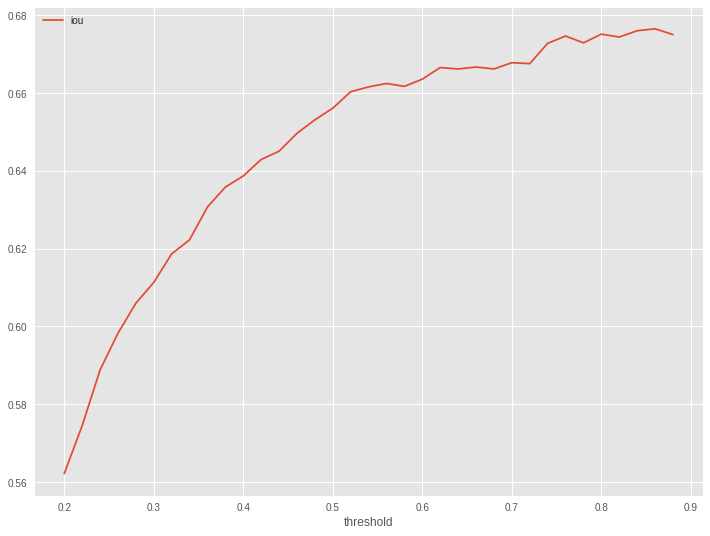

In [60]:
# Plot IoU values over threshold range.
df_iou.plot(x='threshold', y='iou')

### RESNET

In [66]:
from IPython.display import Image, display_png
display_png(Image("ダウンロード.png"))

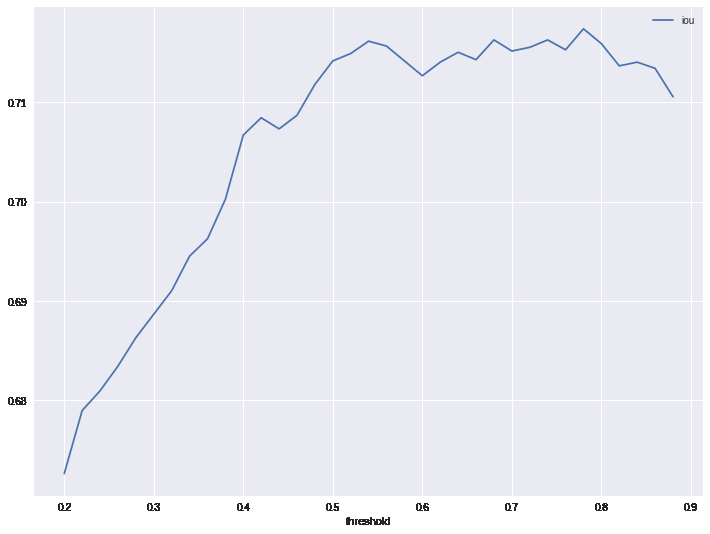

In [69]:
from keras.preprocessing.image import load_img, img_to_array, array_to_img
load_img("/content/ダウンロード.png")